In [2]:
using LinearAlgebra

using GR
using Plots
using LaTeXStrings

using gmsh

# Generate Mesh

In [22]:
gmsh.finalize()
gmsh.initialize()
gmsh.option.setNumber("General.Terminal", 1)
gmsh.model.add("t1")

lc = 1e-1
lc2 = 0.1e-1

gmsh.model.geo.addPoint(0, 0, 0, lc, 1)
gmsh.model.geo.addPoint(1., 0,  0, lc, 2)
gmsh.model.geo.addPoint(1., 1., 0, lc, 3)
gmsh.model.geo.addPoint(0, 1., 0, lc, 4)
gmsh.model.geo.addPoint(0, 0.5, 0, lc2, 5)
gmsh.model.geo.addPoint(1, 0.5, 0, lc2, 6)

gmsh.model.geo.addLine(1, 2, 1)
gmsh.model.geo.addLine(2, 6, 2)
gmsh.model.geo.addLine(6, 5, 3)
gmsh.model.geo.addLine(5, 1, 4)
gmsh.model.geo.addLine(6, 3, 5)
gmsh.model.geo.addLine(3, 4, 6)
gmsh.model.geo.addLine(4, 5, 7)

gmsh.model.geo.addCurveLoop([1,2,3,4], 1)
gmsh.model.geo.addCurveLoop([-3,5,6,7], 2)

gmsh.model.geo.addPlaneSurface([1], 1)
gmsh.model.geo.addPlaneSurface([2], 2)

# Domains
gmsh.model.addPhysicalGroup(2, [1], 1)
gmsh.model.addPhysicalGroup(2, [2], 2)

# Boundaries
gmsh.model.addPhysicalGroup(1, [1], 1)
gmsh.model.setPhysicalName(1, 1, "D1")
gmsh.model.addPhysicalGroup(0, [1, 2], 1)
gmsh.model.setPhysicalName(0, 1, "D1p")

gmsh.model.addPhysicalGroup(1, [6], 2)
gmsh.model.setPhysicalName(1, 2, "D2")
gmsh.model.addPhysicalGroup(0, [3, 4], 2)
gmsh.model.setPhysicalName(0, 2, "D2p")

gmsh.model.addPhysicalGroup(1, [2, 4, 5, 7], 3)
gmsh.model.setPhysicalName(1, 3, "N1")

gmsh.model.geo.synchronize()
gmsh.model.mesh.generate(2)

gmsh.write("es_planar.msh")

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 50%] Meshing curve 4 (Line)
Info    : [ 60%] Meshing curve 5 (Line)
Info    : [ 80%] Meshing curve 6 (Line)
Info    : [ 90%] Meshing curve 7 (Line)
Info    : Done meshing 1D (Wall 0.0129671s, CPU 0.015625s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 50%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0852869s, CPU 0.078125s)
Info    : 1389 nodes 2882 elements
Info    : Writing 'es_planar.msh'...
Info    : Done writing 'es_planar.msh'


In [23]:
gmsh.fltk.run();

-------------------------------------------------------
Version       : 4.9.4
License       : GNU General Public License
Build OS      : Windows64-sdk
Build date    : 20220203
Build host    : gmsh.info
Build options : 64Bit ALGLIB[contrib] ANN[contrib] Bamg Blas[petsc] Blossom Cgns DIntegration DomHex Eigen[contrib] Fltk Gmm[contrib] Hxt Jpeg Kbipack Lapack[petsc] MathEx[contrib] Med Mesh Metis[contrib] Mmg Mpeg Netgen NoSocklenT ONELAB ONELABMetamodel OpenCASCADE OpenCASCADE-CAF OpenGL OpenMP OptHom PETSc Parser Plugins Png Post QuadMeshingTools QuadTri Solver TetGen/BR Voro++[contrib] WinslowUntangler Zlib
FLTK version  : 1.4.0
PETSc version : 3.15.0 (real arithmtic)
OCC version   : 7.6.0
MED version   : 4.1.0
Packaged by   : nt authority system
Web site      : https://gmsh.info
Issue tracker : https://gitlab.onelab.info/gmsh/gmsh/issues
-------------------------------------------------------


In [4]:
#..2/11 Get and sort the mesh nodes
#..Observe that although the mesh is two-dimensional,
#..the z-coordinate that is equal to zero is stored as well.
#..Observe that the coordinates are stored contiguously for computational
#..efficiency
node_ids, node_coord, _ = gmsh.model.mesh.getNodes()
nnodes = length(node_ids)
#..sort the node coordinates by ID, such that Node one sits at row 1
tosort = [node_ids node_coord[1:3:end] node_coord[2:3:end]];
sorted = sortslices(tosort , dims = 1);
node_ids = sorted[:,1];
xnode = sorted[:,2];
ynode = sorted[:,3];

#trisurf(xnode, ynode, ones(length(xnode)))

# 2D FEM

In [6]:
function bnd_dirichlet(A, f, n, e, u)
    nids_n = gmsh.model.mesh.getNodes.(0, n);
    nids_e = gmsh.model.mesh.getNodes.(1, e);
    
    nids = [nids_n[i][1][1] for i = 1:length(nids_n)];
    for i = 1:length(nids_e)
        nids = vcat(nids, nids_e[i][1])
    end
    
    A[nids,:]    .= 0;
    A[nids,nids]  = Diagonal(ones(size(nids)))
    f[nids]      .= u;
    
    return A, f;
end

function bnd_neumann(A, f, n, e, up)
    nids_n = gmsh.model.mesh.getNodes.(0, n);
    nids_e = gmsh.model.mesh.getNodes.(1, e);
    
    nids = [nids_n[i][1][1] for i = 1:length(nids_n)];
    for i = 1:length(nids_e)
        nids = vcat(nids, nids_e[i][1])
    end
    
    f[nids] .+= up;
    
    return A, f;
end

bnd_neumann (generic function with 1 method)

In [24]:
#..4/11 Get the mesh elements
#..observe that we get all the two-dimensional triangular elements from the mesh
element_types, element_ids, element_connectivity = gmsh.model.mesh.getElements(2)
nelements = length(element_ids[1])

#..5/11 Define the source function and apply the source function to the local coordinates
sourcefunction(x,y) = 0;
cfun(x,y) = 3 * (y < 0.5) + 1 * (y >= 0.5);
fvalues = map(sourcefunction, xnode, ynode)

#..6/11 initialize global matrix A and global vector f
#..observe that for simplicity we use dense matrix here
A = zeros(nnodes,nnodes)
f = zeros(nnodes,1)

#..7/11 Perform a loop over the elements
for element_id in 1:nelements
    #....retrieve global numbering of the local nodes of the current element
    node1_id = element_connectivity[1][3*(element_id-1)+1]
    node2_id = element_connectivity[1][3*(element_id-1)+2]
    node3_id = element_connectivity[1][3*(element_id-1)+3]

    #....retrieve the x and y coordinates of the local nodes of the current element
    xnode1 = xnode[node1_id]; xnode2 = xnode[node2_id]; xnode3 = xnode[node3_id];
    ynode1 = ynode[node1_id]; ynode2 = ynode[node2_id]; ynode3 = ynode[node3_id];

    #....compute surface area of the current element
    x12 = xnode2 - xnode1; x13 = xnode3-xnode1;
    y12 = ynode2 - ynode1; y13 = ynode3-ynode1;
    area_id = x12*y13 - x13*y12; area_id = abs(area_id)/2

    #....compute local vector contribution floc of the current element
    floc = area_id / 3 * [fvalues[node1_id]; fvalues[node2_id]; fvalues[node3_id]]

    #....compute local matrix contribution Aloc of the current element
    Emat = [[xnode1;xnode2;xnode3] [ynode1;ynode2;ynode3] [1;1;1]] \ UniformScaling(1.);
    Emat[3,:] .= 0;
    Aloc = area_id * (transpose(Emat) * Emat);
    Aloc = Aloc * 1/3 * (cfun(xnode1, ynode1) + cfun(xnode2, ynode2) + cfun(xnode3, ynode3))
    
    #....add local contribution to f and A
    I      = element_connectivity[1][3 * (element_id - 1) .+ (1:3)];
    f[I]   += floc;
    A[I,I] += Aloc;
end

#..8/11 Handle the boundary conditions
#..retrieve boundary nodes by loop over corner point and boundary edges
A, f = bnd_dirichlet(A, f, [1, 2], [1], 0);
A, f = bnd_dirichlet(A, f, [3, 4], [6], 1);
A, f = bnd_neumann(A, f, [5, 6], [2, 4, 5, 7], 0);

#..9/11 Compute the numerical solution
u = A \ f;

#..10/11 Plot the numerical solution
#tricont(xnode,ynode,u)
#trisurf(xnode,ynode,u)

In [25]:
E = zeros(nelements);
for element_id in 1:nelements
    #....retrieve global numbering of the local nodes of the current element
    node1_id = element_connectivity[1][3*(element_id-1)+1]
    node2_id = element_connectivity[1][3*(element_id-1)+2]
    node3_id = element_connectivity[1][3*(element_id-1)+3]

    #....retrieve the x and y coordinates of the local nodes of the current element
    xnode1 = xnode[node1_id]; xnode2 = xnode[node2_id]; xnode3 = xnode[node3_id];
    ynode1 = ynode[node1_id]; ynode2 = ynode[node2_id]; ynode3 = ynode[node3_id];

    #....compute local matrix contribution Aloc of the current element
    Emat = [[xnode1;xnode2;xnode3] [ynode1;ynode2;ynode3] [1;1;1]] \ UniformScaling(1.);
    Emat[3,:] .= 0;
    
    c1 = u[node1_id];
    c2 = u[node2_id];
    c3 = u[node3_id];
    
    Ex = c1 * Emat[1,1] + c2 * Emat[1, 2] + c3 * Emat[1, 3];
    Ey = c1 * Emat[2,1] + c2 * Emat[2, 2] + c3 * Emat[2, 3];
    E[element_id] = sqrt(Ex^2 + Ey^2);
end

In [26]:
using WriteVTK

In [27]:
cells = [MeshCell(VTKCellTypes.VTK_TRIANGLE, element_connectivity[1][3*(i-1).+(1:3)]) for i = 1:nelements];
points = [xnode ynode]';

In [28]:
vtkfile = vtk_grid("es_planar.vtu", points, cells);
vtkfile["V", VTKPointData()] = u';
vtkfile["E", VTKCellData()] = E;
outfiles = vtk_save(vtkfile);

In [3]:
using Gridap
using GridapGmsh

In [26]:
# Build geometry using CartesianDiscreteModel
model = GmshDiscreteModel("es_planar.msh")

# Create a reference finite element space to use for the construction of test space V0
#  The FE space is Lagrangian and of order 1
order = 1
reffe = ReferenceFE(lagrangian, Float64, order);
# The test space is created from the reference FE with
#  conformity = H1: shape functions are continuous
#  D1 and D2 being the boundary points with Dirichlet condition applied
V0 = TestFESpace(model, reffe; conformity = :H1, dirichlet_tags = ["D1", "D1p", "D2", "D2p"]);

# Trial space is constructed from the test space
#  the [0, 1] indicates the values of the Dirichlet condition at D1 and D2
Ug = TrialFESpace(V0, [0, 0, 1, 1]);

# Triangulation of the domain
#  degree must be at least 2 times the order of the reference space
degree = 2 * order;
Ω = Triangulation(model);
dΩ = Measure(Ω, degree);

Info    : Reading 'es_planar.msh'...
Info    : 15 entities
Info    : 1389 nodes
Info    : 2780 elements
Info    : Done reading 'es_planar.msh'


In [27]:
# Define source function and variable diffusion coefficient
fsource(x) = 0;
cfun(x) = 3 * (x[2] < 0.5) + 1 * (x[2] >= 0.5);

# Construct weak form
lhs(u,v) = ∫( cfun * ∇(v) ⋅ ∇(u) )dΩ;
rhs(v)   = ∫( v * fsource  )dΩ; #+ ∫( cfun * ∇(u) * v)dΓ;

# Construct FE operator with LHS, RHS, and test and trial spaces
op = AffineFEOperator(lhs, rhs, Ug, V0);

# Solve the linear FE system with LU solver
ls = LUSolver()
solver = LinearFESolver(ls)

uh = solve(solver, op);

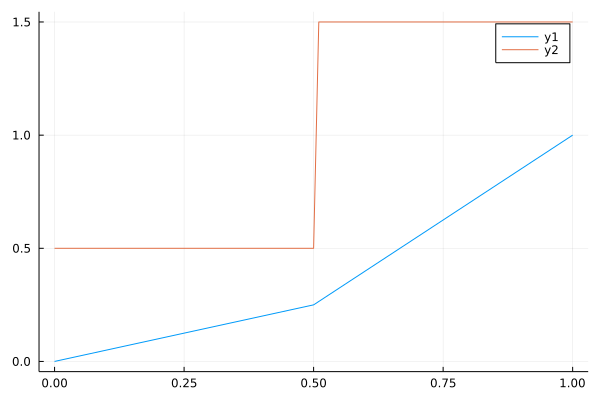

In [57]:
# Evaluate solution on line
y = Vector(0:0.01:1)
coord = [Point(0, y[i]) for i in 1:length(y)];
u_line = uh(coord);
E_line = Eh(coord);

E_line = [sqrt(E[1]^2 + E[2]^2)  for E in E_line];

Plots.plot(y, u_line)
Plots.plot!(y, E_line)

In [58]:
writevtk(Ω, "es_planar_Gridap", cellfields=["uh" => uh, "Eh" => Eh])

(["es_planar_Gridap.vtu"],)